The Following is an attempt to replicate the findings of the 2015 paper [***Distilling the Knowledge in a Neural Network***](https://arxiv.org/pdf/1503.02531) , I have done it for only the first experiment with MNIST data. There are 2 other experiments which you can read in the paper to look at the results which provides that knowledge distillation happens in neural network.

##What is Knowledge Distillation ?

Knowledge distillation is a technique where a small, fast neural network (the "student") is trained to mimic the behavior of a large, powerful, and slow network (the "teacher").

###An analogy
Imagine you have two people:

**The Teacher:** A world-class coffee expert who can taste a coffee and not only identify the country it's from but also guess the region, the roast type, and detect subtle notes of chocolate or berry.

**The Student:** A new barista in training.

Normal Training would be like just telling the student the right answer: "This coffee is from Colombia." The student only learns that one fact.

**Knowledge Distillation** is like having the expert tell the student their full thought process: "This is very likely from Colombia, specifically the Huila region. It's a medium roast, and I'm getting strong notes of dark chocolate and a hint of cherry."

*The student* learns much more from the expert's detailed description than from just the simple answer. Even though the student is less experienced, they learn to think like the expert and can make much better, more nuanced guesses on their own.


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import numpy as np
import pandas as pd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Loading the MNIST data set (Contains Image tensor 28*28 with hard labels)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
print(f'Train data size: {len(train_data)}')
print(f'Test data size: {len(test_data)}')
print(f'Train data shape: {train_data[0][0].shape}')
print(f'Test data shape: {test_data[0][0].shape}')
print(train_data[0][0])

Train data size: 60000
Test data size: 10000
Train data shape: torch.Size([1, 28, 28])
Test data shape: torch.Size([1, 28, 28])
tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.

In [ ]:
# The Teacher Neural Network with 784 -> 1200 -> 1200 -> 10 Neurons in it. (In the original paper they added dropout layers for better which i have skipped here)
class Teachernet(nn.Module):
    def __init__(self):
        super(Teachernet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1200),
            nn.ReLU(),
            nn.Linear(1200, 1200),
            nn.ReLU(),
            nn.Linear(1200, 10)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

In [ ]:
# Training Loop for the teacher model
def train_teacher(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

In [ ]:
# Training Teacher Model using cross entropy loss and a learnig rate of 0.001 and only 1 epoch
teacher_model = Teachernet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(teacher_model.parameters(), lr=0.001)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
train_teacher(teacher_model, train_loader, criterion, optimizer, epochs=1)

Epoch [1/1], Loss: 0.1936


In [ ]:
# Evaluation function to test any model against the 10000 test cases of the MNIST data set
def evaluate(model,test_data):
    model.eval()
    test_loader = DataLoader(test_data,batch_size=1000,shuffle=False)
    correct=0
    total=0
    with torch.no_grad():
        for images,labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the 10000 test images: {accuracy} %')
    return accuracy
# Teacher net evaluation after training
teacher_accuracy = evaluate(teacher_model, test_data)

Accuracy of the model on the 10000 test images: 96.87 %


In [ ]:
# The Base Neural Network with 784 -> 800 -> 800 -> 10 Neurons in it.
class Basestudentnet(nn.Module):
    def __init__(self):
        super(Basestudentnet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 800),
            nn.ReLU(),
            nn.Linear(800, 800),
            nn.ReLU(),
            nn.Linear(800, 10)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

In [ ]:
# A replica of Base Neural Network with 784 -> 800 -> 800 -> 10 Neurons in it. This is the model to be trained on tecahers soft output and hard labels
class Distilledstudentnet(nn.Module):
    def __init__(self):
        super(Distilledstudentnet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 800),
            nn.ReLU(),
            nn.Linear(800, 800),
            nn.ReLU(),
            nn.Linear(800, 10)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

In [ ]:
# Training the base student model with the teacher training loop since both only differ in number of neurons in the hidden layer
base_student_model = Basestudentnet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(base_student_model.parameters(), lr=0.001)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
train_teacher(base_student_model, train_loader, criterion, optimizer, epochs=1)

Epoch [1/1], Loss: 0.1929


In [ ]:
# The evaluation of the base student net on the standard MNIST test data
base_student_accuracy = evaluate(base_student_model, test_data)

Accuracy of the model on the 10000 test images: 96.15 %


In [ ]:
# Preparation of new training data set by passing the 60000 images form the original dataset through the teacher model
teacher_model.eval()
new_train_data = []
train_loader_for_distill = DataLoader(train_data, batch_size=64, shuffle=False)

with torch.no_grad():
    for images, labels in train_loader_for_distill:
        images, labels = images.to(device), labels.to(device)
        teacher_outputs = teacher_model(images)
        # For each item in the batch, creating a tuple of (image, label, teacher_output)
        for i in range(images.size(0)):
            new_train_data.append((images[i].cpu(), labels[i].cpu(), teacher_outputs[i].cpu()))

print(f"Created new training data with {len(new_train_data)} samples.")
# The new_train_data is a list of tuples, which can be used to create a new DataLoader
# for training the distilled student model.

Created new training data with 60000 samples.


In [ ]:
# The new data has 3 parts , image tensor , label(true label),tecaher outputs which is a distribution between 0 to 9
print(new_train_data[0])

(tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -

In [ ]:
# Setting up distill loss to be used with cross entropy loss
def distill_loss(student_outputs, teacher_outputs, temperature, alpha):

    # Soft targets from teacher
    soft_teacher_targets = F.softmax(teacher_outputs / temperature, dim=1)
    soft_student_outputs = F.log_softmax(student_outputs / temperature, dim=1)

    # Soft target loss (KLD)
    soft_loss = F.kl_div(soft_student_outputs, soft_teacher_targets, reduction='batchwise') * (temperature**2)

    # Hard target loss (CrossEntropy)
    # Note: We need the true labels for hard target loss.
    # Assuming the data loader provides true labels.
    # This part will be added in the training loop.
    return soft_loss

def train_distilled_student(student_model, new_train_data, criterion_hard, optimizer, epochs, temperature=2.0, alpha=0.5):
    student_model.train()
    # Create a DataLoader from the new_train_data
    distill_train_loader = DataLoader(new_train_data, batch_size=64, shuffle=True)

    for epoch in range(epochs):
        total_loss = 0
        for images, true_labels, teacher_outputs in distill_train_loader:
            images, true_labels, teacher_outputs = images.to(device), true_labels.to(device), teacher_outputs.to(device)

            optimizer.zero_grad()
            student_outputs = student_model(images)

            # Calculate soft target loss
            soft_teacher_targets = F.softmax(teacher_outputs / temperature, dim=1)
            soft_student_outputs = F.log_softmax(student_outputs / temperature, dim=1)
            # kl_div stands for KL divergence which is measure of how one probability distribution diverges from a second, expected probability distribution.(Read below cell)
            soft_loss = F.kl_div(soft_student_outputs, soft_teacher_targets, reduction='batchmean') * (temperature**2)


            # Calculate hard target loss
            hard_loss = criterion_hard(student_outputs, true_labels)

            # Combine losses
            loss = alpha * soft_loss + (1 - alpha) * hard_loss

            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(distill_train_loader):.4f}")

The Kullback-Leibler Divergence (also called relative entropy) is a measure of how one probability distribution diverges from a second, expected probability distribution.

In [ ]:
# Training the distilled student net model with temperature 20 because original paper mentions 20 (Poor Memory lead remembering late hence in upper code it also has a value)
distilled_student_model = Distilledstudentnet().to(device)
criterion_hard = nn.CrossEntropyLoss() # Criterion for hard target loss
optimizer = optim.Adam(distilled_student_model.parameters(), lr=0.001)

train_distilled_student(distilled_student_model, new_train_data, criterion_hard, optimizer, epochs=1, temperature=20.0, alpha=0.5)

Epoch [1/1], Loss: 0.4169


In [ ]:
# Evaluating Distilled student net model
distilled_student_accuracy = evaluate(distilled_student_model, test_data)

Accuracy of the model on the 10000 test images: 97.32 %


In [ ]:
# Similar student net configuration to train only on teachers soft output i.e not taking in the loss for the hard targets
class Distilledstudentnet1(nn.Module):
    def __init__(self):
        super(Distilledstudentnet1, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 800),
            nn.ReLU(),
            nn.Linear(800, 800),
            nn.ReLU(),
            nn.Linear(800, 10)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

In [ ]:
# Training loop to train student net without taking consideration of the loss of the hard targets
def train_distilled_student1(student_model, new_train_data, optimizer, epochs, temperature=2.0):
    student_model.train()
    distill_train_loader = DataLoader(new_train_data, batch_size=64, shuffle=True)

    for epoch in range(epochs):
        total_loss = 0
        for images, _, teacher_outputs in distill_train_loader:  # ignore true_labels
            images, teacher_outputs = images.to(device), teacher_outputs.to(device)

            optimizer.zero_grad()
            student_outputs = student_model(images)

            # Calculate soft target loss only
            soft_teacher_targets = F.softmax(teacher_outputs / temperature, dim=1)
            soft_student_outputs = F.log_softmax(student_outputs / temperature, dim=1)
            loss = F.kl_div(soft_student_outputs, soft_teacher_targets, reduction='batchmean') * (temperature**2)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(distill_train_loader):.4f}")

In [ ]:
# Training distilled student model with out taking loss of hard target ... thats why the crossentropy loss is not passed
distilled_student_model1 = Distilledstudentnet1().to(device)
# criterion_hard = nn.CrossEntropyLoss() # Criterion for hard target loss
optimizer = optim.Adam(distilled_student_model.parameters(), lr=0.001)

train_distilled_student1(distilled_student_model1, new_train_data, optimizer, epochs=1, temperature=20.0)

Epoch [1/1], Loss: 22.4724


In [ ]:
# Evaluating the trained model and as you see it performs very badly which indicates how only soft targets cannnot teach a student model
distilled_student_accuracy1 = evaluate(distilled_student_model1, test_data)

Accuracy of the model on the 10000 test images: 11.05 %


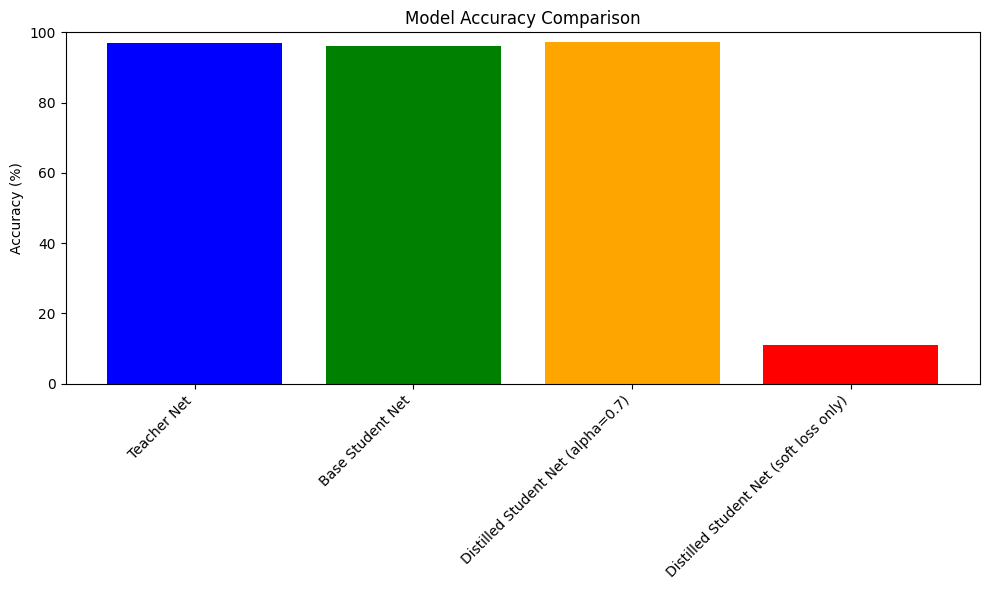

In [ ]:
# Bar graph to see the result of 4 models trained

import matplotlib.pyplot as plt

model_names = ['Teacher Net', 'Base Student Net', 'Distilled Student Net (alpha=0.7)', 'Distilled Student Net (soft loss only)']
accuracies = [teacher_accuracy, base_student_accuracy, distilled_student_accuracy, distilled_student_accuracy1]

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['blue', 'green', 'orange', 'red'])
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

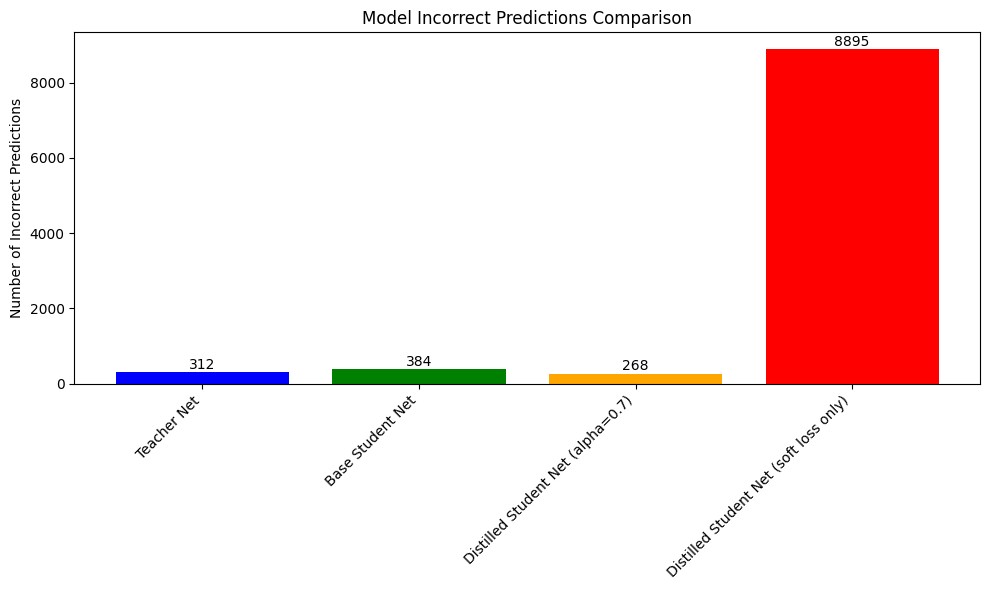

In [ ]:
# Realized as the diff between accuracy is very low , plotted the number of failed results in the test case for proper visualization

model_names = ['Teacher Net', 'Base Student Net', 'Distilled Student Net (alpha=0.7)', 'Distilled Student Net (soft loss only)']
accuracies = [teacher_accuracy, base_student_accuracy, distilled_student_accuracy, distilled_student_accuracy1]
total_test_images = len(test_data)

incorrect_predictions = [total_test_images * (100 - acc) / 100 for acc in accuracies]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, incorrect_predictions, color=['blue', 'green', 'orange', 'red'])
plt.ylabel('Number of Incorrect Predictions')
plt.title('Model Incorrect Predictions Comparison')
plt.xticks(rotation=45, ha='right')

# Add count labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Exp-2

 In this Experiment we take out a random image here label 3 , from both the original train data set and the data set which had image tensor, hard label and tecaher outputs. In the original paper they did the same to show case the fact that a student model can also learn about a mystic label given tecahers soft targets which has some information about the mystic label ...They i.e (*Hinton , Vinyals, Dean*) call this ***Dark knowledge*** which supposedly gets transferred while ***knowledge distillation***.

In [ ]:
# Distilled student net with the same configuration as earlier

class Distilledstudentnet3(nn.Module):
    def __init__(self):
        super(Distilledstudentnet3, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 800),
            nn.ReLU(),
            nn.Linear(800, 800),
            nn.ReLU(),
            nn.Linear(800, 10)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

In [ ]:
#Base student net with same configuration as earlier
class Basestudentnet3(nn.Module):
    def __init__(self):
        super(Basestudentnet3, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 800),
            nn.ReLU(),
            nn.Linear(800, 800),
            nn.ReLU(),
            nn.Linear(800, 10)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

In [ ]:
# Creation of new data set from the original train data set with hard labels by removing label 3
train_data_no_3 = []
removed_count = 0
for image, label in train_data:
    if label != 3:
        train_data_no_3.append((image, label))
    else:
        removed_count += 1

print(f"Number of images with label '3' removed from train_data: {removed_count}")

Number of images with label '3' removed from train_data: 6131


In [ ]:
# New data set for distilled student net by removing label 3 from the dataset that was earlier used to train distill student net
new_train_data_no_3 = []
removed_count = 0
for image, label, teacher_output in new_train_data:
    if label != 3:
        new_train_data_no_3.append((image, label, teacher_output))
    else:
        removed_count += 1

print(f"Number of images with label '3' removed from new_train_data: {removed_count}")

Number of images with label '3' removed from new_train_data: 6131


In [ ]:
# Counting the number of label 3 in the test data set
count_of_threes_test = 0
for _, label in test_data:
    if label == 3:
        count_of_threes_test += 1

print(f"Total number of '3' images in the test set: {count_of_threes_test}")

Total number of '3' images in the test set: 1010


In [ ]:
# Creation of Dataloader for both this new data
train_loader_no_3 = DataLoader(train_data_no_3, batch_size=64, shuffle=True)
distill_train_loader_no_3 = DataLoader(new_train_data_no_3, batch_size=64, shuffle=True)

In [ ]:
# Training base student model with the original train data with missing label 3
base_student_model_no_3 = Basestudentnet3().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(base_student_model_no_3.parameters(), lr=0.001)
train_teacher(base_student_model_no_3, train_loader_no_3, criterion, optimizer, epochs=1)

Epoch [1/1], Loss: 0.1732


In [ ]:
# Evaluating base student model trained above to see how many incorrect identifications it did for label 3 though it was not trained on label 3
base_student_model_no_3.eval()
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)
correct = 0
total = 0
incorrect_threes = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = base_student_model_no_3(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Count incorrect predictions for label '3'
        for i in range(labels.size(0)):
            if labels[i] == 3 and predicted[i] != 3:
                incorrect_threes += 1

accuracy = 100 * correct / total
print(f'Overall accuracy of Basestudentnet3 on the 10000 test images: {accuracy} %')
print(f'Total number of "3" images in the test set: {count_of_threes_test}')
print(f'Number of incorrect predictions for label "3" by Basestudentnet3: {incorrect_threes}')

Overall accuracy of Basestudentnet3 on the 10000 test images: 87.34 %
Total number of "3" images in the test set: 1010
Number of incorrect predictions for label "3" by Basestudentnet3: 1010


In [ ]:
# Training the distilled student net on the missing label 3 data with both hard targets and soft target from the teacher model which learnt from data having label 3
distilled_student_model_no_3 = Distilledstudentnet3().to(device)
criterion_hard = nn.CrossEntropyLoss()
optimizer = optim.Adam(distilled_student_model_no_3.parameters(), lr=0.001)

train_distilled_student(distilled_student_model_no_3, new_train_data_no_3, criterion_hard, optimizer, epochs=1, temperature=20.0, alpha=0.5)

Epoch [1/1], Loss: 0.4106


In [ ]:
# Evaluating Distilled student model trained above to see how many incorrect identifications it did for label 3 though it was not trained on label 3
distilled_student_model_no_3.eval()
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)
correct = 0
total = 0
incorrect_threes = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = distilled_student_model_no_3(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Count incorrect predictions for label '3'
        for i in range(labels.size(0)):
            if labels[i] == 3 and predicted[i] != 3:
                incorrect_threes += 1

accuracy = 100 * correct / total
print(f'Overall accuracy of Distilledstudentnet3 on the 10000 test images: {accuracy} %')
print(f'Total number of "3" images in the test set: {count_of_threes_test}')
print(f'Number of incorrect predictions for label "3" by Distilledstudentnet3: {incorrect_threes}')

Overall accuracy of Distilledstudentnet3 on the 10000 test images: 95.7 %
Total number of "3" images in the test set: 1010
Number of incorrect predictions for label "3" by Distilledstudentnet3: 206


## As you can see above it only gave 206 times incorrect results for label 3 out of 1010 images that represented 3. Which is similar to what was the result shown in the orignal paper.
## We see that the knowledge of identifying label 3 was passed to student model from the soft distributions of the teacher model output.